### Нейронная сеть для настройки тонового классификатора сообщений Twitter

Twitter – это социальная сеть и сервис микроблогинга, который позволяет пользователям писать сообщения в реальном времени. Зачастую сообщение пишется с мобильного устройства прямо с места событий, что добавляет сообщению эмоциональности. Из-за ограничения платформы длина твиттер-сообщения не превышает 140 символов. В связи с этой особенностью сервиса (короткие сообщения публикуются в реальном времени) люди используют аббревиатуры, сокращают слова, используют смайлики, пишут с орфографическими ошибками. Так как twitter имеет особенности социальной сети, его пользователи могут активно выражать свое мнение относительно разнообразных тем: от качества мультиварок до экономических и политических событий в мире.

Важно определить окраску (положительная или отрицательная) отдельно взятого предложения, а не абзацев или целых документов. В длинном документе мнение автора об объекте может меняться с положительного на отрицательное и наоборот; автор может отрицательно высказываться о мелких недочетах, но в целом оставаться положительно настроенным по отношению к объекту. Другими словами, не всегда длинный документ или отзыв однозначно можно классифицировать как положительно или отрицательно окрашенный.

Классификация на уровне коротких сообщений Twitter использует размеченный корпус Ю. В. Рубцовой (Институт систем информатики им. А.П. Ершова СО РАН)   
http://www.swsys.ru/index.php?page=article&id=3962&lang=

In [1]:
!nvidia-smi

Sun Sep 13 08:54:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import re
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
import dill as pickle
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!ls 'drive/My Drive/Colab Notebooks/data'

all_twitts.csv	model.h5    twitts.pkl	x_train.pkl
cycle_gan	model.json  x_test.pkl


In [6]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/data/all_twitts.csv', sep = ';', encoding='utf-8')

In [7]:
df.head()

,index,tdate,tmane,ttext,ttype,tstcount,tfol,tfrien
0,0,2013-12-06 13:32:24,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,8064,111
1,1,2013-12-06 13:32:37,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,26,42
2,2,2013-12-06 13:32:46,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,718,49
3,3,2013-12-06 13:33:00,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,10628,207
4,4,2013-12-06 13:33:00,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,35,17


In [8]:
# Функция предобработки текста для удаления всех нерелевантных символов
def preprocessText(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [9]:
df.ttext = df.ttext.apply(preprocessText)

In [10]:
df.head()

,index,tdate,tmane,ttext,ttype,tstcount,tfol,tfrien
0,0,2013-12-06 13:32:24,dugarchikbellko,на работе был полный пиддес и так каждое закры...,-1,0,8064,111
1,1,2013-12-06 13:32:37,nugemycejela,коллеги сидят рубятся в urban terror а я из за...,-1,0,26,42
2,2,2013-12-06 13:32:46,4post21,как говорят обещаного три года ждут,-1,0,718,49
3,3,2013-12-06 13:33:00,Poliwake,желаю хорошего полета и удачной посадки я буду...,-1,0,10628,207
4,4,2013-12-06 13:33:00,capyvixowe,обновил за каким то лешим surf теперь не работ...,-1,0,35,17


In [11]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 5.4MB/s 


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [13]:
# Загрузка Text embedding
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3')

In [14]:
# Положительные сообщения
good_reviews = df[df.ttype == 1]
# Отрицательные сообщения
bad_reviews = df[df.ttype == -1]

In [15]:
good_text = ' '.join(good_reviews.ttext.to_numpy().tolist())
bad_text = ' '.join(bad_reviews.ttext.to_numpy().tolist())

In [16]:
len(good_text)

7636822

In [17]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=random.seed())

In [18]:
bad_df = bad_reviews

In [19]:
rev_df = good_df.append(bad_df).reset_index(drop=True)

In [20]:
rev_df.head()

,index,tdate,tmane,ttext,ttype,tstcount,tfol,tfrien
0,27060,2013-12-08 10:28:33,iriskaa_iriska,элонка ты не знаешь а шапки и колу раздавали в...,1,0,779,22
1,80099,2013-12-11 14:57:45,ksyunich98,я раньше никого не шипперила а с 12 11 13 я оф...,1,0,20166,2203
2,887,2013-12-06 14:11:52,vetergy,раз дума вводить все больше запретительных зак...,1,0,2136,544
3,69576,2013-12-10 20:33:01,dashadaaasha,были бы там еще конфетки вкусные цены бы им не...,1,0,1373,20
4,25900,2013-12-08 09:23:10,hitafijahul,rt по хорошему надо ехать в универ а по факту ...,1,0,472,159


In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
type_one_hot = OneHotEncoder(sparse=False).fit_transform(rev_df.ttype.to_numpy().reshape(-1,1))

In [23]:
# Разбиение на тренировочную и тестовую выборки
train_rev, test_rev, y_train, y_test = train_test_split(rev_df.ttext, type_one_hot, test_size = 0.1, random_state=random.seed())

In [24]:
X_train = []
for r in tqdm(train_rev):
  emb = embed(r)
  rev_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(rev_emb)

X_train = np.array(X_train)

100%|██████████| 201461/201461 [43:16<00:00, 77.58it/s]


In [25]:
with open('drive/My Drive/Colab Notebooks/data/x_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

In [26]:
X_test = []
for r in tqdm(test_rev):
  emb = embed(r)
  rev_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(rev_emb)

X_test = np.array(X_test)

100%|██████████| 22385/22385 [04:47<00:00, 77.78it/s]


In [27]:
with open('drive/My Drive/Colab Notebooks/data/x_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

In [29]:
 # Построение модели
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [30]:
# Компиляция модели
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [31]:
# Тренировка модели
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/20
11333/11333 [==============================] - 30s 3ms/step - loss: 0.5333 - accuracy: 0.7307 - val_loss: 0.5109 - val_accuracy: 0.7444
Epoch 2/20
11333/11333 [==============================] - 28s 2ms/step - loss: 0.5092 - accuracy: 0.7484 - val_loss: 0.5035 - val_accuracy: 0.7500
Epoch 3/20
11333/11333 [==============================] - 28s 3ms/step - loss: 0.4961 - accuracy: 0.7565 - val_loss: 0.4963 - val_accuracy: 0.7540
Epoch 4/20
11333/11333 [==============================] - 29s 3ms/step - loss: 0.4854 - accuracy: 0.7642 - val_loss: 0.4921 - val_accuracy: 0.7553
Epoch 5/20
11333/11333 [==============================] - 29s 3ms/step - loss: 0.4747 - accuracy: 0.7715 - val_loss: 0.4927 - val_accuracy: 0.7575
Epoch 6/20
11333/11333 [==============================] - 29s 3ms/step - loss: 0.4654 - accuracy: 0.7767 - val_loss: 0.4913 - val_accuracy: 0.7591
Epoch 7/20
11333/11333 [==============================] - 28s 2ms/step - loss: 0.4567 - accuracy: 0.7824 - val_loss: 0

In [32]:
import matplotlib.pyplot as plt

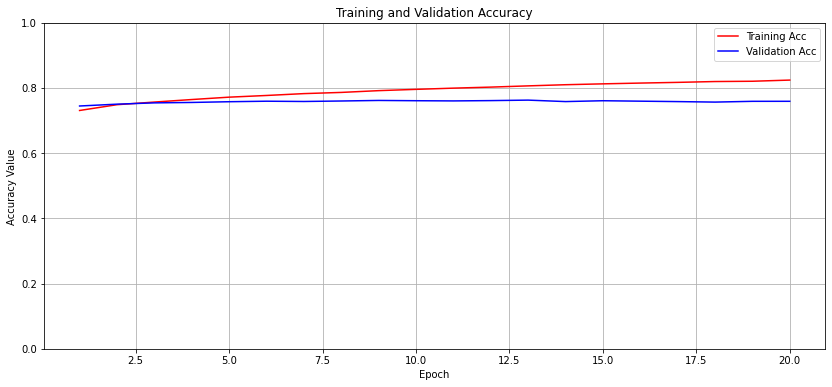

In [33]:
EPOCHS = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.figure(figsize=(14, 6))
plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [34]:
# Оценка модели
model.evaluate(X_test, y_test)

700/700 [==============================] - 1s 2ms/step - loss: 0.5014 - accuracy: 0.7647


[0.5014082193374634, 0.7647085189819336]

In [35]:
# Сохранение модели и весов
model_json = model.to_json()
with open('drive/My Drive/Colab Notebooks/data/model.json', 'w') as file:
  file.write(model_json)
model.save_weights('drive/My Drive/Colab Notebooks/data/model.h5')

In [36]:
# Проверка работы модели на коротких предложениях
sent = ['хорошее утро сегодня']
result = embed(sent)
model.predict(np.array(result))

array([[0.01762624, 0.9823737 ]], dtype=float32)

In [37]:
sent = ['дождливый день']
result = embed(sent)
model.predict(np.array(result))

array([[9.994962e-01, 5.037950e-04]], dtype=float32)

In [38]:
sent = ['пойдем сегодня в кино']
result = embed(sent)
model.predict(np.array(result))

array([[0.14937133, 0.8506287 ]], dtype=float32)